In [ ]:
import numpy as np
import pandas as pd


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import locale
from locale import atof
locale.setlocale(locale.LC_NUMERIC, '')


'en_US.UTF-8'

In [ ]:
myfile = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/2603from201001to202206.csv",thousands=',')

myfile.head(10)

,Date,Open,High,Low,Close,Volume,UpAndDown
0,99/01/04,17.95,18.25,17.80,18.15,3629,0.30
1,99/01/05,18.35,18.85,18.35,18.80,5557,0.65
2,99/01/06,18.95,19.00,18.40,18.50,3031,-0.30
3,99/01/07,18.50,19.10,18.40,18.60,5313,0.10
4,99/01/08,18.70,19.80,18.65,19.60,6358,1.00
5,99/01/11,19.60,20.20,19.40,20.05,4718,0.45
6,99/01/12,20.15,20.25,19.50,19.90,3368,-0.15
7,99/01/13,19.60,19.85,19.10,19.10,2648,-0.80
8,99/01/14,19.10,19.90,19.10,19.60,3668,0.50
9,99/01/15,19.95,20.15,19.70,19.75,2923,0.15


In [ ]:
myfile.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Volume         int64
UpAndDown    float64
dtype: object

In [ ]:
# 將民國年改成西元年使用
# 將date轉換成日期類型
d = myfile['Date']
for i in range(len(d)):
    d.iloc[i]=d.iloc[i].replace(d.iloc[i][0:3], str(int(d.iloc[i][0:3]) + 1911))
d.head()
print('-'*20)
d = pd.to_datetime(d,format='%Y/%m/%d')

# 並將「日期」列設置為索引。
myfile['Date'] = pd.to_datetime(myfile['Date'])

myfile.index = range(len(myfile))
# thedata = myfile.set_index(['Date'], drop=True)
myfile

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


--------------------


,Date,Open,High,Low,Close,Volume,UpAndDown
0,2010-01-04,17.95,18.25,17.80,18.15,3629,0.30
1,2010-01-05,18.35,18.85,18.35,18.80,5557,0.65
2,2010-01-06,18.95,19.00,18.40,18.50,3031,-0.30
3,2010-01-07,18.50,19.10,18.40,18.60,5313,0.10
4,2010-01-08,18.70,19.80,18.65,19.60,6358,1.00
...,...,...,...,...,...,...,...
3050,2022-06-13,134.00,134.50,130.00,130.50,63339,-8.50
3051,2022-06-14,129.00,132.00,128.50,131.50,42825,1.00
3052,2022-06-15,131.50,132.50,128.00,128.00,51324,-3.50
3053,2022-06-16,130.00,130.50,119.00,119.50,91675,-8.50


In [ ]:
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree # we use this to train meachine
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Time series decomposition
!pip install stldecompose
from stldecompose import decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
thedata = myfile

In [ ]:
thedata

,Date,Open,High,Low,Close,Volume,UpAndDown
0,2010-01-04,17.95,18.25,17.80,18.15,3629,0.30
1,2010-01-05,18.35,18.85,18.35,18.80,5557,0.65
2,2010-01-06,18.95,19.00,18.40,18.50,3031,-0.30
3,2010-01-07,18.50,19.10,18.40,18.60,5313,0.10
4,2010-01-08,18.70,19.80,18.65,19.60,6358,1.00
...,...,...,...,...,...,...,...
3050,2022-06-13,134.00,134.50,130.00,130.50,63339,-8.50
3051,2022-06-14,129.00,132.00,128.50,131.50,42825,1.00
3052,2022-06-15,131.50,132.50,128.00,128.00,51324,-3.50
3053,2022-06-16,130.00,130.50,119.00,119.50,91675,-8.50


In [ ]:
fig = make_subplots(rows=1, cols=1)

fig.add_trace(go.Ohlc(x=thedata.Date,
            open=thedata.Open,
            high=thedata.High,
            low=thedata.Low,
            close=thedata.Close,
            name='Price'), row=1, col=1)

# fig.add_trace(go.Scatter(x=thedata.Date, y=thedata.Volume, name='Volume'), row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)

fig.show()


In [ ]:
df_close = thedata[['Date', 'Close']].copy()
df_close = df_close.set_index('Date')
df_close.head()

,Close
Date,
2010-01-04,18.15
2010-01-05,18.80
2010-01-06,18.50
2010-01-07,18.60
2010-01-08,19.60


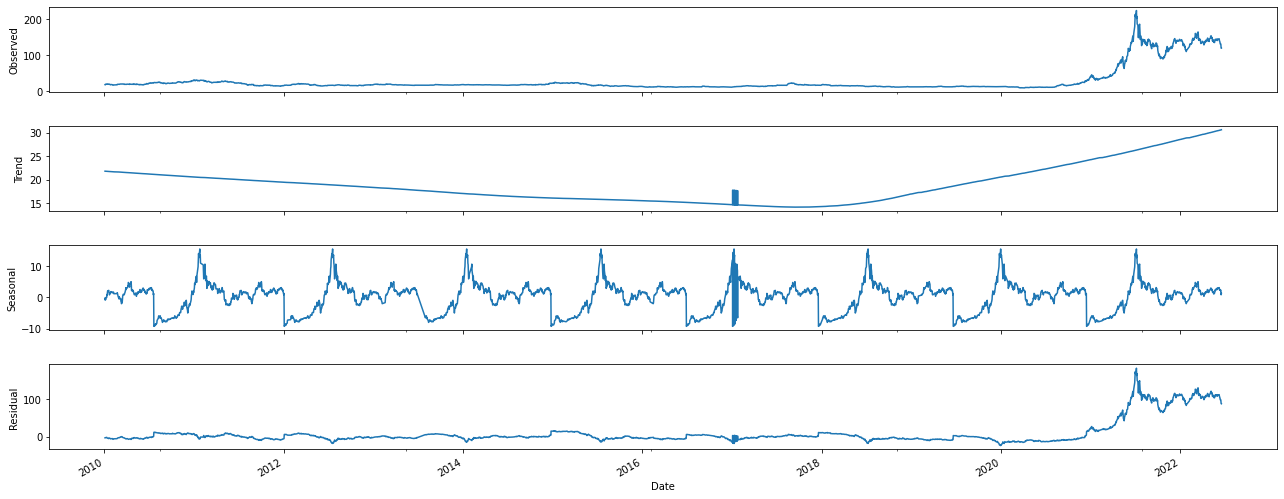

In [ ]:
#Create a seasonal-trend (with Loess, aka "STL")
#  decomposition of observed time series data.
decomp = decompose(df_close, period=365)
fig = decomp.plot()
fig.set_size_inches(20, 8)
fig.show()

In [ ]:
# 畫移動頻均線

thedata['EMA_9'] = thedata['Close'].ewm(9).mean().shift()
# rolling(5).mean() is the mean of the previous 5 periods
# for example 5/15 includeing and previous 5 day
#5/11 ~ 5/15
thedata['SMA_5'] = thedata['Close'].rolling(5).mean().shift()
thedata['SMA_10'] = thedata['Close'].rolling(10).mean().shift()
thedata['SMA_15'] = thedata['Close'].rolling(15).mean().shift()
thedata['SMA_30'] = thedata['Close'].rolling(30).mean().shift()

fig = go.Figure()
fig.add_trace(go.Scatter(x=thedata.Date, y=thedata.EMA_9, name='EMA 9'))
fig.add_trace(go.Scatter(x=thedata.Date, y=thedata.SMA_5, name='SMA 5'))
fig.add_trace(go.Scatter(x=thedata.Date, y=thedata.SMA_10, name='SMA 10'))
fig.add_trace(go.Scatter(x=thedata.Date, y=thedata.SMA_15, name='SMA 15'))
fig.add_trace(go.Scatter(x=thedata.Date, y=thedata.SMA_30, name='SMA 30'))
fig.add_trace(go.Scatter(x=thedata.Date, y=thedata.Close, name='Close', opacity=0.2))
# fig.write_image("/content/drive/MyDrive/Colab Notebooks/some_MA.jpg")
fig.show()

In [ ]:
thedata

,Date,Open,High,Low,Close,Volume,UpAndDown,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30
0,2010-01-04,17.95,18.25,17.80,18.15,3629,0.30,NaN,NaN,NaN,NaN,NaN
1,2010-01-05,18.35,18.85,18.35,18.80,5557,0.65,18.150000,NaN,NaN,NaN,NaN
2,2010-01-06,18.95,19.00,18.40,18.50,3031,-0.30,18.492105,NaN,NaN,NaN,NaN
3,2010-01-07,18.50,19.10,18.40,18.60,5313,0.10,18.495018,NaN,NaN,NaN,NaN
4,2010-01-08,18.70,19.80,18.65,19.60,6358,1.00,18.525545,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
3050,2022-06-13,134.00,134.50,130.00,130.50,63339,-8.50,142.325519,142.5,143.05,142.433333,143.116667
3051,2022-06-14,129.00,132.00,128.50,131.50,42825,1.00,141.142967,139.9,141.65,142.133333,142.866667
3052,2022-06-15,131.50,132.50,128.00,128.00,51324,-3.50,140.178671,137.3,140.40,141.300000,142.416667
3053,2022-06-16,130.00,130.50,119.00,119.50,91675,-8.50,138.960804,133.8,139.15,140.366667,141.800000


In [ ]:
# RSI
def relative_strength_idx(df, n=14):
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

thedata['RSI'] = relative_strength_idx(thedata).fillna(0)

fig = go.Figure(go.Scatter(x=thedata.Date, y=thedata.RSI, name='RSI'))

fig.show()

In [ ]:
thedata

,Date,Open,High,Low,Close,Volume,UpAndDown,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI
0,2010-01-04,17.95,18.25,17.80,18.15,3629,0.30,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-05,18.35,18.85,18.35,18.80,5557,0.65,18.150000,NaN,NaN,NaN,NaN,0.000000
2,2010-01-06,18.95,19.00,18.40,18.50,3031,-0.30,18.492105,NaN,NaN,NaN,NaN,0.000000
3,2010-01-07,18.50,19.10,18.40,18.60,5313,0.10,18.495018,NaN,NaN,NaN,NaN,0.000000
4,2010-01-08,18.70,19.80,18.65,19.60,6358,1.00,18.525545,NaN,NaN,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3050,2022-06-13,134.00,134.50,130.00,130.50,63339,-8.50,142.325519,142.5,143.05,142.433333,143.116667,29.230769
3051,2022-06-14,129.00,132.00,128.50,131.50,42825,1.00,141.142967,139.9,141.65,142.133333,142.866667,33.333333
3052,2022-06-15,131.50,132.50,128.00,128.00,51324,-3.50,140.178671,137.3,140.40,141.300000,142.416667,27.941176
3053,2022-06-16,130.00,130.50,119.00,119.50,91675,-8.50,138.960804,133.8,139.15,140.366667,141.800000,22.891566


In [ ]:
# MACD
EMA_12 = pd.Series(thedata['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(thedata['Close'].ewm(span=26, min_periods=26).mean())
thedata['MACD'] = pd.Series(EMA_12 - EMA_26)
thedata['MACD_signal'] = pd.Series(thedata.MACD.ewm(span=9, min_periods=9).mean())

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=thedata.Date, y=thedata.Close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=thedata.Date, y=EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=thedata.Date, y=EMA_26, name='EMA 26'), row=1, col=1)
fig.add_trace(go.Scatter(x=thedata.Date, y=thedata['MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=thedata.Date, y=thedata['MACD_signal'], name='Signal line'), row=2, col=1)

fig.show()

In [ ]:
thedata

,Date,Open,High,Low,Close,Volume,UpAndDown,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,2010-01-04,17.95,18.25,17.80,18.15,3629,0.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-05,18.35,18.85,18.35,18.80,5557,0.65,18.150000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
2,2010-01-06,18.95,19.00,18.40,18.50,3031,-0.30,18.492105,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
3,2010-01-07,18.50,19.10,18.40,18.60,5313,0.10,18.495018,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
4,2010-01-08,18.70,19.80,18.65,19.60,6358,1.00,18.525545,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3050,2022-06-13,134.00,134.50,130.00,130.50,63339,-8.50,142.325519,142.5,143.05,142.433333,143.116667,29.230769,-0.954968,-0.035552
3051,2022-06-14,129.00,132.00,128.50,131.50,42825,1.00,141.142967,139.9,141.65,142.133333,142.866667,33.333333,-1.599668,-0.348375
3052,2022-06-15,131.50,132.50,128.00,128.00,51324,-3.50,140.178671,137.3,140.40,141.300000,142.416667,27.941176,-2.365748,-0.751849
3053,2022-06-16,130.00,130.50,119.00,119.50,91675,-8.50,138.960804,133.8,139.15,140.366667,141.800000,22.891566,-3.617055,-1.324891


# **Shift label column**

我要預測幾天後就shif多少天



In [ ]:
predict1day = thedata.copy()
# predict10day = thedata.copy()
# predict30day = thedata.copy()

In [ ]:
predict1day['Close'] = predict1day['Close'].shift(-1)
# predict10day['Close'] = predict10day['Close'].shift(-10)
# predict30day['Close'] = predict30day['Close'].shift(-30)

In [ ]:
thedata

,Date,Open,High,Low,Close,Volume,UpAndDown,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,2010-01-04,17.95,18.25,17.80,18.15,3629,0.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-05,18.35,18.85,18.35,18.80,5557,0.65,18.150000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
2,2010-01-06,18.95,19.00,18.40,18.50,3031,-0.30,18.492105,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
3,2010-01-07,18.50,19.10,18.40,18.60,5313,0.10,18.495018,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
4,2010-01-08,18.70,19.80,18.65,19.60,6358,1.00,18.525545,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3050,2022-06-13,134.00,134.50,130.00,130.50,63339,-8.50,142.325519,142.5,143.05,142.433333,143.116667,29.230769,-0.954968,-0.035552
3051,2022-06-14,129.00,132.00,128.50,131.50,42825,1.00,141.142967,139.9,141.65,142.133333,142.866667,33.333333,-1.599668,-0.348375
3052,2022-06-15,131.50,132.50,128.00,128.00,51324,-3.50,140.178671,137.3,140.40,141.300000,142.416667,27.941176,-2.365748,-0.751849
3053,2022-06-16,130.00,130.50,119.00,119.50,91675,-8.50,138.960804,133.8,139.15,140.366667,141.800000,22.891566,-3.617055,-1.324891


In [ ]:
predict1day

,Date,Open,High,Low,Close,Volume,UpAndDown,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,2010-01-04,17.95,18.25,17.80,18.80,3629,0.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-05,18.35,18.85,18.35,18.50,5557,0.65,18.150000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
2,2010-01-06,18.95,19.00,18.40,18.60,3031,-0.30,18.492105,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
3,2010-01-07,18.50,19.10,18.40,19.60,5313,0.10,18.495018,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
4,2010-01-08,18.70,19.80,18.65,20.05,6358,1.00,18.525545,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3050,2022-06-13,134.00,134.50,130.00,131.50,63339,-8.50,142.325519,142.5,143.05,142.433333,143.116667,29.230769,-0.954968,-0.035552
3051,2022-06-14,129.00,132.00,128.50,128.00,42825,1.00,141.142967,139.9,141.65,142.133333,142.866667,33.333333,-1.599668,-0.348375
3052,2022-06-15,131.50,132.50,128.00,119.50,51324,-3.50,140.178671,137.3,140.40,141.300000,142.416667,27.941176,-2.365748,-0.751849
3053,2022-06-16,130.00,130.50,119.00,119.50,91675,-8.50,138.960804,133.8,139.15,140.366667,141.800000,22.891566,-3.617055,-1.324891


# **Drop invalid samples**


ex 30日均線的前30筆都是NA 因為資料開始到第30日才有第一筆30MA

In [ ]:
# from 33 to end
predict1day = predict1day.iloc[33:] # Because of moving averages and MACD line

# remove the right most one
predict1day = predict1day[:-1]      # Because of shifting close price

predict1day.index = range(len(predict1day))

predict1day.head()

,Date,Open,High,Low,Close,Volume,UpAndDown,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,2010-02-26,19.00,19.20,18.80,19.00,2157,0.10,18.163449,18.34,17.725,17.896667,18.530000,57.000000,0.012579,-0.193960
1,2010-03-01,19.20,19.35,18.90,18.65,1824,-0.20,18.270070,18.72,17.870,17.976667,18.550000,57.575758,0.063246,-0.136331
2,2010-03-02,19.00,19.15,18.60,19.05,1661,-0.35,18.344937,18.98,18.110,18.010000,18.530000,53.773585,0.075830,-0.089911
3,2010-03-03,18.80,19.05,18.65,19.15,1356,0.40,18.376146,18.93,18.315,18.036667,18.483333,57.522124,0.115016,-0.045902
4,2010-03-04,19.15,19.65,18.85,19.60,3842,0.10,18.444926,19.00,18.495,18.090000,18.455000,63.207547,0.151940,-0.004031


In [ ]:
# predict1day = predict1day[(predict1day['Date'].dt.year >= 2021)]

In [ ]:
predict1day.reset_index(inplace=True, drop=True)
predict1day

,Date,Open,High,Low,Close,Volume,UpAndDown,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,2010-02-26,19.00,19.20,18.80,19.00,2157,0.10,18.163449,18.34,17.725,17.896667,18.530000,57.000000,0.012579,-0.193960
1,2010-03-01,19.20,19.35,18.90,18.65,1824,-0.20,18.270070,18.72,17.870,17.976667,18.550000,57.575758,0.063246,-0.136331
2,2010-03-02,19.00,19.15,18.60,19.05,1661,-0.35,18.344937,18.98,18.110,18.010000,18.530000,53.773585,0.075830,-0.089911
3,2010-03-03,18.80,19.05,18.65,19.15,1356,0.40,18.376146,18.93,18.315,18.036667,18.483333,57.522124,0.115016,-0.045902
4,2010-03-04,19.15,19.65,18.85,19.60,3842,0.10,18.444926,19.00,18.495,18.090000,18.455000,63.207547,0.151940,-0.004031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3016,2022-06-10,138.50,140.00,137.00,130.50,28276,-1.00,142.695022,143.60,143.350,142.233333,143.150000,56.060606,-0.016387,0.194302
3017,2022-06-13,134.00,134.50,130.00,131.50,63339,-8.50,142.325519,142.50,143.050,142.433333,143.116667,29.230769,-0.954968,-0.035552
3018,2022-06-14,129.00,132.00,128.50,128.00,42825,1.00,141.142967,139.90,141.650,142.133333,142.866667,33.333333,-1.599668,-0.348375
3019,2022-06-15,131.50,132.50,128.00,119.50,51324,-3.50,140.178671,137.30,140.400,141.300000,142.416667,27.941176,-2.365748,-0.751849


In [ ]:
# test_size  = 0.05
# valid_size = 0.10

# test_split_idx  = int(predict1day.shape[0] * (1-test_size))
# valid_split_idx = int(predict1day.shape[0] * (1-(valid_size+test_size)))

# print(test_split_idx)
# print(valid_split_idx)

# train_df1  = predict1day.loc[:valid_split_idx].copy()
# valid_df1  = predict1day.loc[valid_split_idx+1:test_split_idx].copy()
# test_df1   = predict1day.loc[test_split_idx+1:].copy()

train_df1  = predict1day.loc[:2909].copy()
valid_df1  = predict1day.loc[2910:2999].copy()
test_df1  = predict1day.loc[3000:].copy()


fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df1.Date, y=train_df1.Close, name='Training'))
fig.add_trace(go.Scatter(x=valid_df1.Date, y=valid_df1.Close, name='Validation'))
fig.add_trace(go.Scatter(x=test_df1.Date,  y=test_df1.Close,  name='Test'))
#
fig.show()

In [ ]:
predict1day.dtypes

Date           datetime64[ns]
Open                  float64
High                  float64
Low                   float64
Close                 float64
Volume                  int64
UpAndDown             float64
EMA_9                 float64
SMA_5                 float64
SMA_10                float64
SMA_15                float64
SMA_30                float64
RSI                   float64
MACD                  float64
MACD_signal           float64
dtype: object

In [ ]:
# drop unnecessary cloumns
# only reseeve "Close"
# drop_cols = ['Date', 'Volume', 'Open', 'Low', 'High', 'UpAndDown']
drop_cols = ['Date','Volume']

train_df1 = train_df1.drop(drop_cols, 1)
valid_df1 = valid_df1.drop(drop_cols, 1)
test_df1  = test_df1.drop(drop_cols, 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



In [ ]:
test_df1.dtypes

Open           float64
High           float64
Low            float64
Close          float64
UpAndDown      float64
EMA_9          float64
SMA_5          float64
SMA_10         float64
SMA_15         float64
SMA_30         float64
RSI            float64
MACD           float64
MACD_signal    float64
dtype: object

In [ ]:
test_df1

,Open,High,Low,Close,UpAndDown,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
3000,137.5,138.5,137.0,136.0,2.0,142.806535,140.0,145.40,144.166667,141.466667,47.572816,-0.539784,0.765914
3001,134.0,136.5,130.0,135.0,-1.5,142.275882,138.6,144.00,144.066667,141.433333,48.039216,-0.958781,0.420975
3002,137.0,138.5,134.5,144.0,-1.0,141.648294,138.0,142.35,143.800000,141.516667,38.888889,-1.355901,0.065600
3003,138.0,147.0,137.5,142.0,9.0,140.983464,136.3,140.45,143.600000,141.733333,47.619048,-0.933634,-0.134247
3004,145.5,146.5,142.0,143.0,-2.0,141.285118,137.6,140.15,143.533333,142.016667,40.404040,-0.751703,-0.257738
3005,144.5,146.0,141.5,142.0,1.0,141.356606,138.9,139.45,143.233333,142.216667,40.404040,-0.520826,-0.310355
3006,144.5,145.0,141.0,144.5,-1.0,141.520945,140.0,139.30,142.666667,142.500000,37.755102,-0.413776,-0.331039
3007,144.5,145.5,142.5,144.0,2.5,141.568851,141.2,139.60,141.966667,142.566667,47.191011,-0.125759,-0.289983
3008,145.5,146.0,144.0,140.5,-0.5,141.861966,143.1,139.70,141.333333,142.783333,44.186047,0.061442,-0.219698
3009,145.0,146.0,140.5,144.5,-3.5,142.075769,143.1,140.35,141.133333,142.866667,45.238095,-0.071793,-0.190117


In [ ]:
# Split into features and labels

y_train1 = train_df1['Close'].copy()
X_train1 = train_df1.drop(['Close'], 1)

y_valid1 = valid_df1['Close'].copy()
X_valid1 = valid_df1.drop(['Close'], 1)

y_test1  = test_df1['Close'].copy()
X_test1  = test_df1.drop(['Close'], 1)

X_train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2910 entries, 0 to 2909
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         2910 non-null   float64
 1   High         2910 non-null   float64
 2   Low          2910 non-null   float64
 3   UpAndDown    2910 non-null   float64
 4   EMA_9        2910 non-null   float64
 5   SMA_5        2910 non-null   float64
 6   SMA_10       2910 non-null   float64
 7   SMA_15       2910 non-null   float64
 8   SMA_30       2910 non-null   float64
 9   RSI          2910 non-null   float64
 10  MACD         2910 non-null   float64
 11  MACD_signal  2910 non-null   float64
dtypes: float64(12)
memory usage: 272.9 KB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



In [ ]:
%%time

parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42]
}

eval_set = [(X_train1, y_train1), (X_valid1, y_valid1)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(X_train1, y_train1)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

Best params: {'gamma': 0.01, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 200, 'random_state': 42}
Best validation score = 0.7247024366629243
CPU times: user 19min 25s, sys: 6.89 s, total: 19min 32s
Wall time: 19min 37s


In [ ]:
%%time

model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train1, y_train1, eval_set=eval_set, verbose=False)

CPU times: user 1.1 s, sys: 4 ms, total: 1.1 s
Wall time: 1.1 s


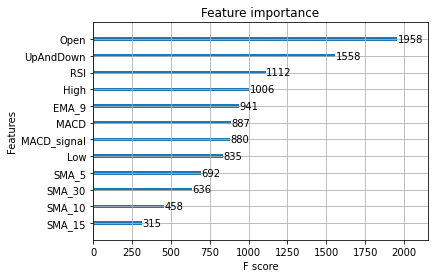

In [ ]:
plot_importance(model);

In [ ]:
# Calculate and visualize predictions
y_pred1 = model.predict(X_test1)
# print(f'y_true = {np.array(y_test1)[:5]}')
# print(f'y_pred = {y_pred1[:5]}')
print(f'y_true = {np.array(y_test1)}')
print(f'y_pred = {y_pred1}')

y_true = [136.  135.  144.  142.  143.  142.  144.5 144.  140.5 144.5 144.5 143.5
 144.5 145.5 140.  139.  130.5 131.5 128.  119.5 119.5]
y_pred = [135.77554 130.84225 131.36716 140.00322 139.49042 140.0473  139.8045
 139.25847 136.62726 136.66324 137.03865 136.40512 140.84401 138.36697
 143.07468 140.46191 136.24524 128.75578 131.55511 131.01852 121.62575]


In [ ]:
print(y_test1)

3000    136.0
3001    135.0
3002    144.0
3003    142.0
3004    143.0
3005    142.0
3006    144.5
3007    144.0
3008    140.5
3009    144.5
3010    144.5
3011    143.5
3012    144.5
3013    145.5
3014    140.0
3015    139.0
3016    130.5
3017    131.5
3018    128.0
3019    119.5
3020    119.5
Name: Close, dtype: float64


In [ ]:
print(f'mean_squared_error = {mean_squared_error(y_test1, y_pred1)}')

mean_squared_error = 32.866894513789916


In [ ]:
# predicted_prices = predict1day.loc[test_split_idx+1:].copy()
predicted_prices = predict1day.loc[3000:].copy()
predicted_prices['Close'] = y_pred1

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=predict1day.Date, y=predict1day.Close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=predicted_prices.Close,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_test1,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_pred1,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show()

# trace one is overall plot
# trace two is the prediction and true overlapping plot